In [3]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


In [4]:
class SoybeanDataset(Dataset):
    def __init__(self, images_dir, annotations_path, transform=None):
        """
        Args:
            images_dir (str): Directory with all the images.
            annotations_path (str): Path to the annotations JSON file (in COCO format).
            transform (callable, optional): Transform to be applied to the images.
        """
        self.images_dir = images_dir
        self.transform = transform
        
        with open(annotations_path, 'r') as f:
            self.annotations = json.load(f)

        self.images = self.annotations['images']
        self.annotations_dict = self._prepare_annotations()

    def _prepare_annotations(self):
        """
        Prepare annotation data in a dictionary for fast lookup.
        """
        annotations_dict = {}
        for ann in self.annotations['annotations']:
            image_id = ann['image_id']
            bbox = ann['bbox']  # Format: [x, y, width, height]
            if image_id not in annotations_dict:
                annotations_dict[image_id] = []
            annotations_dict[image_id].append(bbox)
        return annotations_dict

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        image_id = img_info['id']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Get bounding boxes for this image
        bboxes = self.annotations_dict.get(image_id, [])

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, bboxes


In [ ]:
import os

# Paths
original_images_dir = "./sample_images"
annotated_images_dir = "./annotations"

# List annotated image files
annotated_files = os.listdir(annotated_images_dir)

# Rename original files to match annotated file names because Roboflow often appends unique identifiers to file names when exporting annotated images or datasets. 
for annotated_file in annotated_files:
    if annotated_file.startswith("Sample") and annotated_file.endswith(".jpg"):
        original_file = annotated_file.split("_")[0] + ".JPG"  # Match the base name
        original_path = os.path.join(original_images_dir, original_file)
        if os.path.exists(original_path):
            new_path = os.path.join(original_images_dir, annotated_file)
            os.rename(original_path, new_path)
            print(f"Renamed: {original_file} -> {annotated_file}")
        else:
            print(f"Original file not found: {original_file}")


Renamed: Sample10.JPG -> Sample10_JPG.rf.24e4e9c48218e00c953d304103aa2ecb.jpg
Renamed: Sample11.JPG -> Sample11_JPG.rf.d93b4f40910e069e5ef6e8668fb6dfa3.jpg
Renamed: Sample12.JPG -> Sample12_JPG.rf.4e10403b60ec1393a417f8ed978d66cb.jpg
Renamed: Sample13.JPG -> Sample13_JPG.rf.a799a3a308cb0b468b4920689152db23.jpg
Renamed: Sample14.JPG -> Sample14_JPG.rf.268734c501882ded3b8cedf0c9fe8d48.jpg
Renamed: Sample15.JPG -> Sample15_JPG.rf.9b328137718e721d536c3b6757ad58a5.jpg
Renamed: Sample1.JPG -> Sample1_JPG.rf.7f04d8e33af8f86f5306481992cab266.jpg
Renamed: Sample2.JPG -> Sample2_JPG.rf.aa241d2346bd7c4b99f50c141cf81a62.jpg
Renamed: Sample3.JPG -> Sample3_JPG.rf.47f455306cdccae78c8e7bc3f90ba42c.jpg
Renamed: Sample4.JPG -> Sample4_JPG.rf.2e778d50bd18c53f710f1c53bb880cb6.jpg
Renamed: Sample5.JPG -> Sample5_JPG.rf.915c0b5e1eb4daf91f437fb40f777048.jpg
Renamed: Sample6.JPG -> Sample6_JPG.rf.e55e4adee8b9a34d6037439c395b1514.jpg
Renamed: Sample7.JPG -> Sample7_JPG.rf.73572f0e4105c4ffbebfed9124a93ebc.jpg


In [11]:
# DataLoader Implementation

# Set paths
annotations_path = './annotations/_annotations.coco.json'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create the dataset and DataLoader
dataset = SoybeanDataset(original_images_dir, annotations_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


Unexpected bounding box format: tensor([150])
Unexpected bounding box format: tensor([95])
Unexpected bounding box format: tensor([7.5000], dtype=torch.float64)
Unexpected bounding box format: tensor([6.5000], dtype=torch.float64)


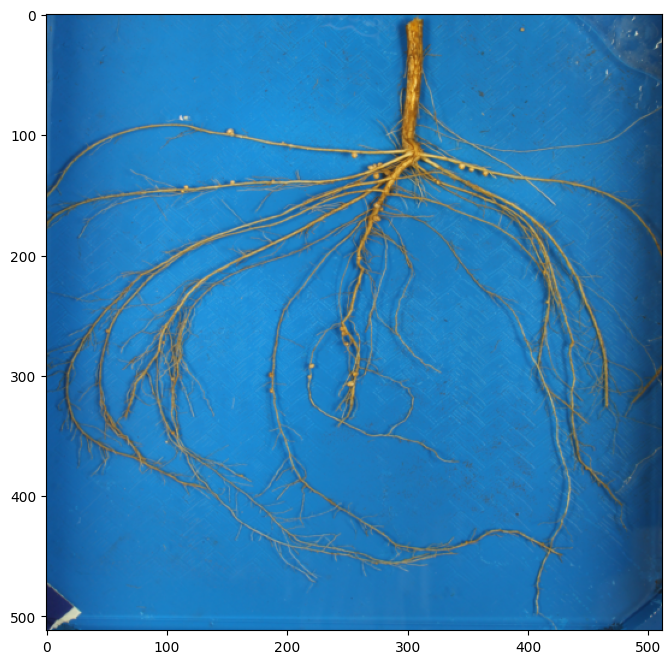

Unexpected bounding box format: tensor([298])
Unexpected bounding box format: tensor([98])
Unexpected bounding box format: tensor([3])
Unexpected bounding box format: tensor([3.5000], dtype=torch.float64)


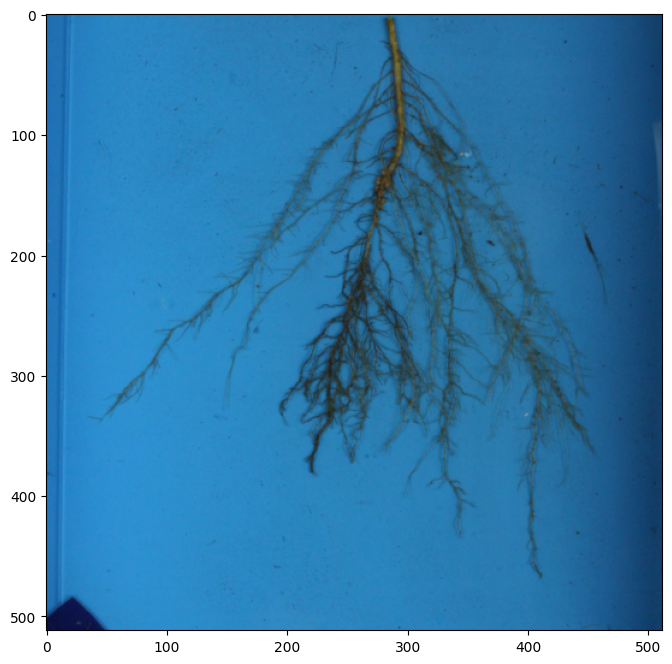

Unexpected bounding box format: tensor([169])
Unexpected bounding box format: tensor([3])
Unexpected bounding box format: tensor([8.5000], dtype=torch.float64)
Unexpected bounding box format: tensor([8.5000], dtype=torch.float64)


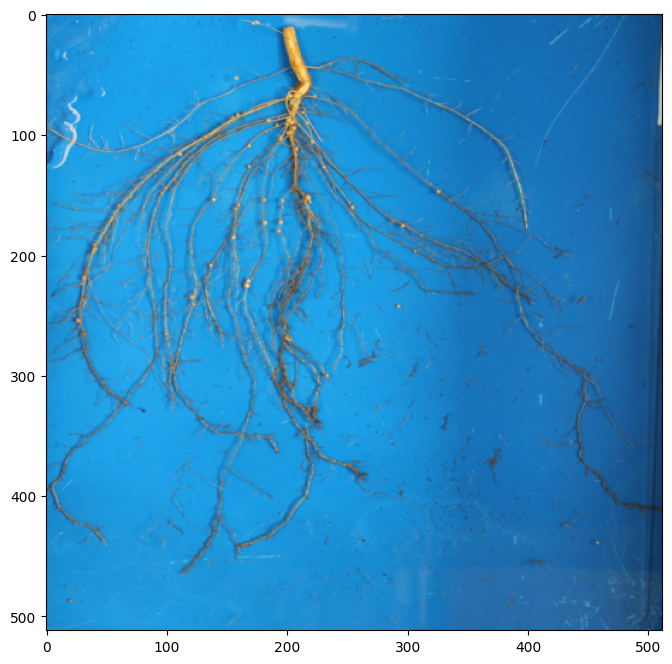

Unexpected bounding box format: tensor([224])
Unexpected bounding box format: tensor([125])
Unexpected bounding box format: tensor([6])
Unexpected bounding box format: tensor([5])


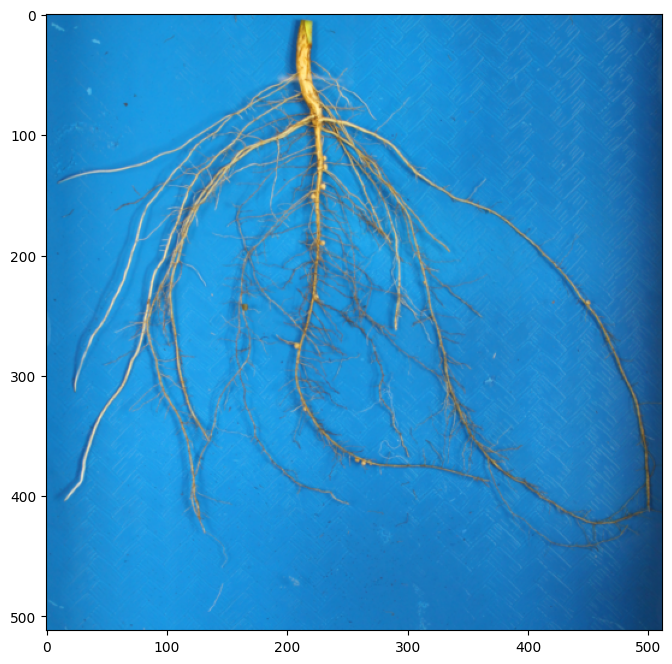

Unexpected bounding box format: tensor([457])
Unexpected bounding box format: tensor([110])
Unexpected bounding box format: tensor([4])
Unexpected bounding box format: tensor([4])


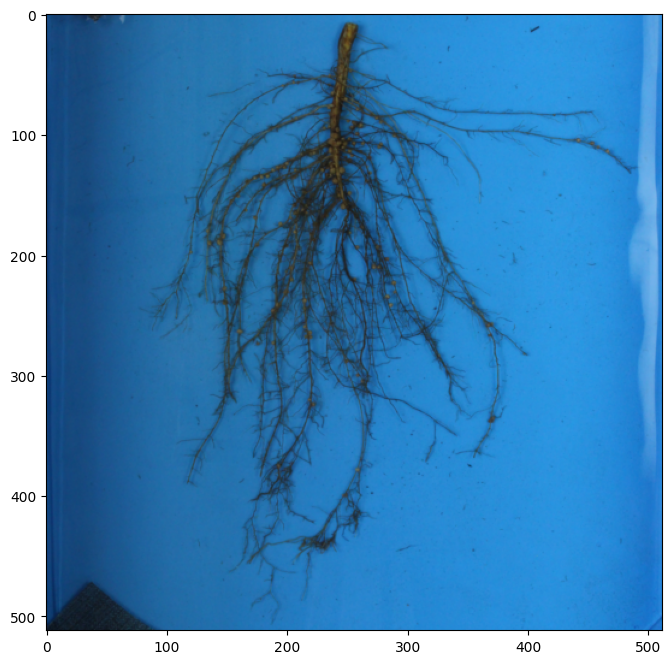

In [20]:
def visualize_sample(image, bboxes, save_path=None):
    """
    Visualize an image with bounding boxes, or save it to a file if display is not working.
    Args:
        image (Tensor): Image tensor of shape (C, H, W).
        bboxes (list): List of bounding boxes.
        save_path (str, optional): Path to save the visualization.
    """
    # Convert image tensor to NumPy array and transpose to (H, W, C)
    image_np = image.permute(1, 2, 0).numpy()
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image_np)

    # Plot bounding boxes
    for bbox in bboxes:
        if len(bbox) == 4:
            # Convert to [x, y, w, h] if needed
            if bbox[2] > bbox[0] and bbox[3] > bbox[1]:  # Assume [x_min, y_min, x_max, y_max]
                x_min, y_min, x_max, y_max = bbox
                x, y = x_min, y_min
                w, h = x_max - x_min, y_max - y_min
            else:
                x, y, w, h = bbox

            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        else:
            print(f"Unexpected bounding box format: {bbox}")

    # Save or show the plot
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    else:
        plt.show()


# Randomly visualize 5 samples from the dataset
for i, (image, bboxes) in enumerate(dataloader):
    if i == 5:
        break
    visualize_sample(image[0], bboxes[0])
